<a href="https://colab.research.google.com/github/1daniel3333/Retirement_Guardrail_Planner/blob/main/GK_%E5%8B%95%E6%85%8B%E6%8F%90%E9%A0%98%E5%9B%9E%E6%B8%AC%E6%A8%A1%E6%93%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GK動態提領策略 歷史回測模擬器 - 使用指南 (User Guide)
歡迎使用「GK動態提領策略 歷史回測模擬器」！

本工具旨在幫助您回測，在採用 Guyton-Klinger (GK) 動態提領規則 的情況下，您的退休資產會如何應對真實發生過的市場歷史。透過這次單一但詳細的回測，您可以觀察您的投資組合在面對歷史上真實的牛市與熊市時，其價值與提領金額會發生什麼樣的變化。

1. 模擬器目標 (Objective)
本回測工具的核心目標是回答以下問題：

如果我的退休生活始於某個特定的歷史年份（例如2000年網路泡沫或2008年金融海嘯前），我的退休金策略能否安然度過危機？

在歷史上真實的市場波動與通膨記錄下，我每年實際能提領的金額會如何變化？

我的資產總額在這段歷史路徑中，最終是成長還是耗盡？

GK規則是一種彈性的提領策略，本模擬器將向您展示它在真實歷史中的實際表現。

2. 如何開始 (How to Get Started)
請依照以下兩個簡單的步驟進行操作：

步驟一：設定您的個人化參數
在下方的程式碼儲存格（標示為「# --- 使用者輸入參數 ---」的區塊）中，您會看到幾個可以修改的變數。請根據您的自身情況填 '寫：

initial_portfolio: 您的初始退休總資產。

initial_withdrawal_rate: 您計畫的初始提領率（例如 0.04 代表 4%）。

市場歷史數據:

本模擬器已內建台股、美股、美債、全球股市自1995年以來的年度報酬率數據。回測將會依照這些真實數據的順序進行。

步驟二：執行模擬
當您設定好所有參數後，就可以執行整個筆記本了。最簡單的方式是：

點擊 Colab 上方選單的「執行階段 (Runtime)」。

在下拉選單中選擇「全部執行 (Run all)」。

程式會從頭到尾運行所有計算與繪圖，您只需稍待片刻即可看到回測結果。

3. 解讀結果 (Interpreting the Results)
執行完畢後，您會看到以下兩個呈現單次回測路徑的結果：

A. 結果數據表 (Results DataFrame)
這份表格詳細列出了回測期間每一年的資產變化，包含以下欄位：

Year: 年度。

Portfolio_Start_Value: 年初資產。

Annual_Withdrawal: 當年度依據GK規則計算出的提領金額。

Portfolio_End_Value: 經歷市場漲跌與提領後，最終的年底資產。

其他欄位：幫助理解GK規則判斷的輔助數據。

您可以透過此表，逐年檢視資產組合的詳細變化。

B. 視覺化圖表 (Result Visualization)
圖表是本次歷史回測結果最直觀的呈現：

藍色線圖 (每年提領金額)：代表您在該歷史情境下，每年實際可以領出的生活費。觀察它如何因應市場狀況而上下調整，是理解GK規則的關鍵。

紅色長條圖 (年底投資組合餘額)：代表您的總資產在歷史上的價值軌跡。您可以清楚看到資產在何時成長、何時因市場衝擊而大幅縮水。

4. 進行實驗 (Experimentation)
這個回測工具最大的價值在於進行「What-if 情境分析」。請不要只執行一次！

您可以回到步驟一，嘗試調整不同的參數組合，來觀察您的策略在同樣的歷史下，是否會產生不同的結果。例如：

「如果我的股票比例從60%降到50%，能幫助我的資產在2008年時虧損少一點嗎？」

「如果我的初始提領率從4%降到3.5%，30年後我的最終資產會多出多少？」

「將不同的歷史報酬率數據（例如將台股換成全球股市）代入，對結果有何影響？」

透過不斷的提問與實驗，您將能更深入地了解您的退休計畫，在真實歷史面前的穩健程度。

免責聲明 (Disclaimer): 本工具所有結果均基於歷史數據，僅供學術研究與個人理- 財規劃參考，不構成任何投資建議。歷史績效不保證未來的回報，請在做出任何財務決策前，諮詢專業的理財顧問。

In [26]:
#@title 1. 設定您的個人化參數 (請在此填寫) { run: "auto", display-mode: "form" }
#@markdown ---
#@markdown ### **基本設定**
#@markdown ##### **依序為初始資產跟初始提領率**
initial_portfolio = 5000000 #@param {type:"number"} # 初始資產 ($)
initial_withdrawal_rate = 0.05 #@param {type:"number"} # 初始提領率 (小數點, 如 4% 請輸入 0.04)


In [27]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [28]:
def gk_dynamic_withdrawal_simulation(
    initial_portfolio_value: float,
    initial_withdrawal_rate: float,
    inflation_rate: float,
    annual_returns: list[float]
) -> pd.DataFrame:
    """
    模擬 GK 動態提領策略。

    Args:
        initial_portfolio_value (float): 初始投資組合總值。
        initial_withdrawal_rate (float): 初始提領率 (例如 0.04 代表 4%)。
        inflation_rate (float): 通膨率 (例如 0.03 代表 3%)。
        annual_returns (list[float]): 每年投資組合的實際報酬率 (例如 [0.05, -0.02, ...])。

    Returns:
        pd.DataFrame: 包含每年模擬結果的 DataFrame。
    """

    num_years = len(annual_returns)

    # 初始化列表來儲存每年的數據
    years = []
    portfolio_values = []
    annual_withdrawals = []
    last_year_returns = [] # 儲存去年的實際報酬率
    current_withdrawal_rates = []
    triggered_rules = []
    recommended_actions = []

    # 第一年計算
    current_portfolio_value = initial_portfolio_value
    current_withdrawal_amount = initial_portfolio_value * initial_withdrawal_rate

    years.append(0) # 假設第0年是退休前一年，用於計算第一年的報酬率
    portfolio_values.append(initial_portfolio_value)
    annual_withdrawals.append(0) # 第0年沒有提領
    last_year_returns.append(0) # 第0年沒有去年報酬率可參考，設為0
    current_withdrawal_rates.append(0)
    triggered_rules.append("N/A")
    recommended_actions.append("N/A")

    print(f"--- GK 動態提領模擬開始 ---")
    print(f"初始投資組合: ${initial_portfolio_value:,.2f}")
    print(f"初始提領率: {initial_withdrawal_rate*100:.2f}%")
    print(f"通膨率: {inflation_rate*100:.2f}%")
    print("-" * 30)

    for i in range(num_years):
        year = i + 1 # 從第1年開始

        # 1. 計算去年的實際投資報酬率
        # 這裡的 annual_returns[i-1] 是指前一年的市場報酬率
        # 但在迴圈中，我們需要的是「前一年」的實際報酬率來判斷通膨規則
        # 由於 annual_returns 已經是按年給出的，我們直接使用 current_portfolio_value 的變化來判斷
        # 為了簡化，我們直接使用 annual_returns[i] 作為當年的市場報酬率，並假設它代表了「去年」的市場表現
        # 實際應用中，annual_returns[i] 應是 Year i 的市場報酬率
        # 這裡我們將 `last_year_return_for_rule` 定義為 `annual_returns[i]`，表示第 i 年結束時的報酬率，用於判斷第 i+1 年的通膨調整
        # 但為了符合 GK 規則「前一年投資組合是否有獲利」，我們需要的是前一年的「淨報酬率」
        # 這裡我們用一個簡化的方式，直接使用 annual_returns[i] 作為判斷依據

        # 為了更精確，我們需要知道「前一年年初總值」和「前一年底總值」來計算「去年投資報酬率」
        # 我們將使用 `portfolio_values` 列表中的前一個值作為「前一年年初總值」
        # 並根據 `annual_returns[i-1]` (如果存在) 來計算「去年底總值」

        # 在這裡，我們需要重新思考 `last_year_return` 的定義
        # 在真實情境中，`last_year_return` 是指「上一個會計年度」的投資組合報酬率
        # 為了模擬，我們假設 `annual_returns[i-1]` 代表了「去年」的市場表現

        # 獲取前一年的投資組合總值 (用於計算報酬率)
        previous_year_start_value = portfolio_values[-1] # 列表的最後一個值是前一年年初的總值

        # 計算去年（即第 i 年）的實際報酬率，用於判斷通膨規則
        # 這裡的 annual_returns[i] 是指當前這一年（Year i+1）的市場報酬率
        # 我們需要的是「Year i」的報酬率來判斷「Year i+1」的通膨調整
        # 因此，我們假設 `annual_returns` 列表中的元素就是對應年份的市場報酬率
        # 為了符合 GK 規則，我們需要判斷的是「前一年」的投資組合是否獲利
        # 所以，我們應該使用 `annual_returns[i-1]` 來判斷 `Year i` 的通膨調整

        # 修正：為了符合「去年投資組合是否有獲利」的判斷，我們需要使用當前循環年份的 `annual_returns[i]`
        # 也就是說，`annual_returns[0]` 是 Year 1 的報酬率，用於判斷 Year 2 的通膨調整
        # 這裡我們將 `last_year_return_for_rule` 設為 `annual_returns[i]`

        # 計算去年（即模擬的當前年份）的實際報酬率，用於通膨規則判斷
        # 這裡的 `annual_returns[i]` 是指「當前這一年」的市場報酬率
        # 我們用它來判斷「下一年」的提領金額是否隨通膨調整
        # 因此，在計算 `Year i+1` 的提領時，我們需要 `Year i` 的報酬率
        # 這裡的 `last_year_return_for_rule` 指的是 `annual_returns[i]`

        # 計算當前年份的投資組合在提領前的價值
        portfolio_before_withdrawal = current_portfolio_value * (1 + annual_returns[i])

        # 1. 通膨規則 (Inflation Rule)
        # 判斷去年的投資組合是否有獲利 (使用 `annual_returns[i]` 作為當前年的市場表現)
        if annual_returns[i] > 0:
            current_withdrawal_amount *= (1 + inflation_rate)
            rule_triggered = "通膨規則 (去年有獲利，提領金額隨通膨調整)"
        else:
            rule_triggered = "通膨規則 (去年虧損，提領金額不隨通膨調整)"

        # 2. 計算當前計算提領率
        current_withdrawal_rate = current_withdrawal_amount / portfolio_before_withdrawal

        # 3. 保本規則 (Capital Preservation Rule - Lowering Withdrawal)
        upper_guardrail_threshold = initial_withdrawal_rate * 1.2 # 初始提領率的 120%
        if current_withdrawal_rate > upper_guardrail_threshold:
            current_withdrawal_amount *= 0.9 # 下調 10%
            rule_triggered += "；保本規則 (提領率過高，下調 10%)"
            recommended_action = "建議將提領金額下調 10% 以保護您的資產壽命。"

        # 4. 繁榮規則 (Prosperity Rule - Raising Withdrawal)
        lower_guardrail_threshold = initial_withdrawal_rate * 0.8 # 初始提領率的 80%
        if current_withdrawal_rate < lower_guardrail_threshold:
            current_withdrawal_amount *= 1.1 # 上調 10%
            rule_triggered += "；繁榮規則 (提領率過低，上調 10%)"
            recommended_action = "恭喜！建議將提領金額上調 10% 以享受市場紅利。"

        # 如果沒有觸發保本或繁榮規則
        if "保本規則" not in rule_triggered and "繁榮規則" not in rule_triggered:
            rule_triggered += "；未觸發保本或繁榮規則"
            recommended_action = "按照基本提領金額提領。"

        # 更新投資組合總值
        current_portfolio_value = portfolio_before_withdrawal - current_withdrawal_amount

        # 儲存結果
        years.append(year)
        portfolio_values.append(current_portfolio_value)
        annual_withdrawals.append(current_withdrawal_amount)
        last_year_returns.append(annual_returns[i]) # 儲存當前年的報酬率，作為下一年的「去年報酬率」
        current_withdrawal_rates.append(current_withdrawal_amount / portfolio_before_withdrawal) # 重新計算調整後的提領率
        triggered_rules.append(rule_triggered)
        recommended_actions.append(recommended_action)

        # print(f"Year {year}:")
        # print(f"  年初投資組合: ${portfolio_values[-2]:,.2f}") # 上一年的年底就是這年的年初
        # print(f"  去年報酬率: {annual_returns[i]*100:.2f}%")
        # print(f"  提領前投資組合: ${portfolio_before_withdrawal:,.2f}")
        # print(f"  計算提領率 (調整前): {current_withdrawal_rate*100:.2f}%")
        # print(f"  觸發規則: {rule_triggered}")
        # print(f"  建議行動: {recommended_action}")
        # print(f"  今年提領金額: ${current_withdrawal_amount:,.2f}")
        # print(f"  年底投資組合: ${current_portfolio_value:,.2f}")
        # print("-" * 30)

    # 建立 DataFrame
    results_df = pd.DataFrame({
        'Year': years[1:], # 從第1年開始顯示
        'Portfolio_Start_Value': portfolio_values[:-1], # 每個年份的年初值
        'Last_Year_Return': last_year_returns[1:], # 顯示去年報酬率
        'Portfolio_Before_Withdrawal': [pv * (1 + ret) for pv, ret in zip(portfolio_values[:-1], annual_returns)], # 提領前價值
        'Calculated_Withdrawal_Rate_Before_Adjustment': current_withdrawal_rates[1:], # 調整前的提領率
        'Triggered_Rules': triggered_rules[1:],
        'Recommended_Action': recommended_actions[1:],
        'Annual_Withdrawal': annual_withdrawals[1:],
        'Portfolio_End_Value': portfolio_values[1:] # 每個年份的年底值
    })

    # 檢查退休金是否耗盡
    if current_portfolio_value <= 0:
        print("\n--- 模擬結果: 退休金已耗盡！ ---")
    else:
        print(f"\n--- 模擬結果: 退休金剩餘 ${current_portfolio_value:,.2f} ---")

    return results_df

# --- 1. 定義一個數字格式化函式 ---
# 這個函式會將大的數字轉換成帶有 K, M, B 後綴的字串
def human_readable_formatter(x, pos):
    """
    Takes a large number and formats it into a human-readable string with K, M, B suffixes.
    x: The value
    pos: The position (required by FuncFormatter, but not used here)
    """
    if x >= 1e9: # 十億 (Billion)
        return f'{x*1e-9:.1f}B'
    if x >= 1e6: # 百萬 (Million)
        return f'{x*1e-6:.1f}M'
    if x >= 1e3: # 千 (Thousand)
        return f'{x*1e-3:.1f}K'
    return f'{x:.0f}' # 小於一千的數字直接顯示

def plot_withdraw_results(simulation_results):
  # --- 圖表英文詞彙對照 (Glossary) ---
  print("--- 圖表英文對照表 Chart Glossary (English to Chinese) ---")
  print("GK Dynamic Withdrawal Simulation Results: GK 動態提領模擬結果")
  print("Year: 年份")
  print("Annual Withdrawal ($): 每年提領金額 ($)")
  print("Year-End Portfolio Value ($): 年底投資組合餘額 ($)")
  print("-------------------------------------------\n")


  # --- 繪製結果圖表 (Plotting Results) ---
  fig, ax1 = plt.subplots(figsize=(12, 7)) # 建立一個圖形和一個主軸

  # 繪製每年提領金額 (左邊 Y 軸，線圖)
  color = 'tab:blue'
  ax1.set_xlabel('Year')
  ax1.set_ylabel('Annual Withdrawal ($)', color=color)
  ax1.plot(simulation_results['Year'], simulation_results['Annual_Withdrawal'], color=color, label='Annual Withdrawal', marker='o', linestyle='-')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.grid(True, linestyle='--', alpha=0.6)

  # 建立第二個 Y 軸，用於投資組合餘額
  ax2 = ax1.twinx()
  color = 'tab:red'
  ax2.set_ylabel('Year-End Portfolio Value ($)', color=color)
  ax2.bar(simulation_results['Year'], simulation_results['Portfolio_End_Value'], color=color, alpha=0.6, label='Year-End Portfolio Value')
  ax2.tick_params(axis='y', labelcolor=color)

  # --- 3. 將格式化函式應用到兩個Y軸 ---
  formatter = FuncFormatter(human_readable_formatter)
  ax1.yaxis.set_major_formatter(formatter) # <--- 應用到左Y軸
  ax2.yaxis.set_major_formatter(formatter) # <--- 應用到右Y軸
  # ------------------------------------

  # 設定圖表標題和圖例
  plt.title('GK Dynamic Withdrawal Simulation Results')

  # 合併兩個軸的圖例
  lines, labels = ax1.get_legend_handles_labels()
  bars, bar_labels = ax2.get_legend_handles_labels()
  ax2.legend(lines + bars, labels + bar_labels, loc='upper left')

  plt.tight_layout() # 自動調整佈局，防止標籤重疊
  plt.show() # 顯示圖表

In [29]:
# @title 歷史數據
def get_random_annual_returns(num_years: int=30) -> list[float]:
  # 範例數據 (您可以替換為真實的歷史報酬率)
  # 假設這是 30 年的年度報酬率
  # 為了方便測試，這裡使用一些隨機數據和一些負數報酬率
  np.random.seed(42) # 確保每次運行結果一致
  sample_annual_returns = np.random.normal(loc=0.07, scale=0.15, size=30).tolist()
  # 確保有一些負數報酬率來測試虧損情況
  sample_annual_returns[2] = -0.20 # 模擬大跌
  sample_annual_returns[7] = -0.10 # 模擬下跌
  sample_annual_returns[15] = 0.01 # 模擬微幅上漲
  sample_annual_returns[20] = -0.05 # 模擬小跌
  return sample_annual_returns

# 台灣加權股價報酬指數 (小數格式)
taiex_returns = [-0.251, 0.379, 0.228, -0.175, 0.554, -0.401, 0.199, -0.171, 0.365, 0.073, 0.101, 0.228, 0.09, -0.431, 0.783, 0.139, -0.18, 0.125, 0.156, 0.112, -0.071, 0.15, 0.177, -0.054, 0.274, 0.27, 0.275, -0.187, 0.305, 0.305]

# S&P 500 指數總報酬率 (小數格式)
sp500_returns = [0.3758, 0.2296, 0.3336, 0.2858, 0.2104, -0.091, -0.1189, -0.221, 0.2868, 0.1088, 0.0491, 0.1579, 0.0549, -0.37, 0.2646, 0.1506, 0.0211, 0.16, 0.3239, 0.1369, 0.0138, 0.1196, 0.2183, -0.0438, 0.3149, 0.184, 0.2871, -0.1811, 0.2629, 0.2331]

# Bloomberg U.S. Aggregate Bond 指數總報酬率 (小數格式)
us_bond_returns = [0.1846, 0.0364, 0.0964, 0.087, -0.0082, 0.1163, 0.0843, 0.1023, 0.041, 0.0434, 0.0243, 0.0433, 0.0697, 0.0524, 0.0593, 0.0654, 0.0784, 0.0421, -0.0202, 0.0597, 0.0055, 0.0265, 0.0354, 0.0001, 0.0872, 0.0751, -0.0154, -0.1301, 0.0553, 0.0125]

# MSCI World 指數總報酬率 (小數格式)
msci_world_returns = [0.2132, 0.14, 0.1623, 0.248, 0.2534, -0.1292, -0.1652, -0.1954, 0.3376, 0.1525, 0.1002, 0.2065, 0.0957, -0.4033, 0.3079, 0.1234, -0.0502, 0.1654, 0.2737, 0.055, -0.0032, 0.0815, 0.2307, -0.082, 0.284, 0.165, 0.2235, -0.1773, 0.2442, 0.1919]

--- GK 動態提領模擬開始 ---
初始投資組合: $5,000,000.00
初始提領率: 5.00%
通膨率: 3.00%
------------------------------

--- 模擬結果: 退休金剩餘 $9,718,967.02 ---

---台灣加權股價報酬指數(台股) 詳細模擬結果 ---

--- 圖表英文對照表 Chart Glossary (English to Chinese) ---
GK Dynamic Withdrawal Simulation Results: GK 動態提領模擬結果
Year: 年份
Annual Withdrawal ($): 每年提領金額 ($)
Year-End Portfolio Value ($): 年底投資組合餘額 ($)
-------------------------------------------



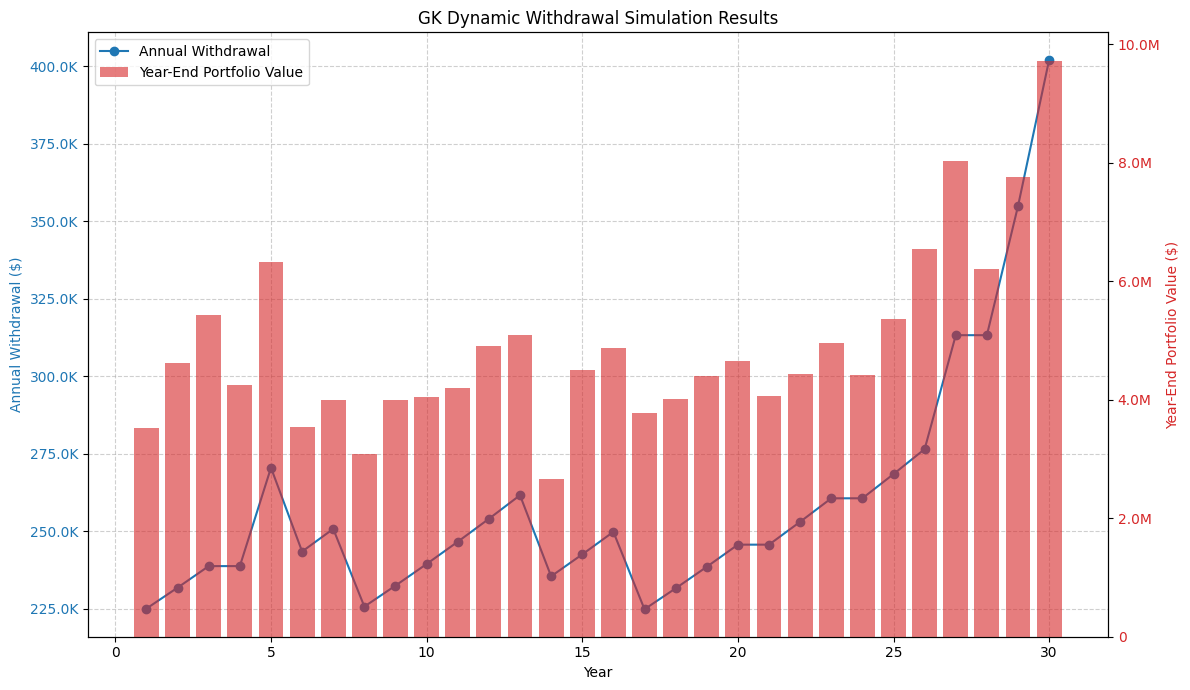

------------------------------


--- GK 動態提領模擬開始 ---
初始投資組合: $5,000,000.00
初始提領率: 5.00%
通膨率: 3.00%
------------------------------

--- 模擬結果: 退休金剩餘 $27,086,616.77 ---

---S&P 500 指數總報酬率(美股) 詳細模擬結果 ---

--- 圖表英文對照表 Chart Glossary (English to Chinese) ---
GK Dynamic Withdrawal Simulation Results: GK 動態提領模擬結果
Year: 年份
Annual Withdrawal ($): 每年提領金額 ($)
Year-End Portfolio Value ($): 年底投資組合餘額 ($)
-------------------------------------------



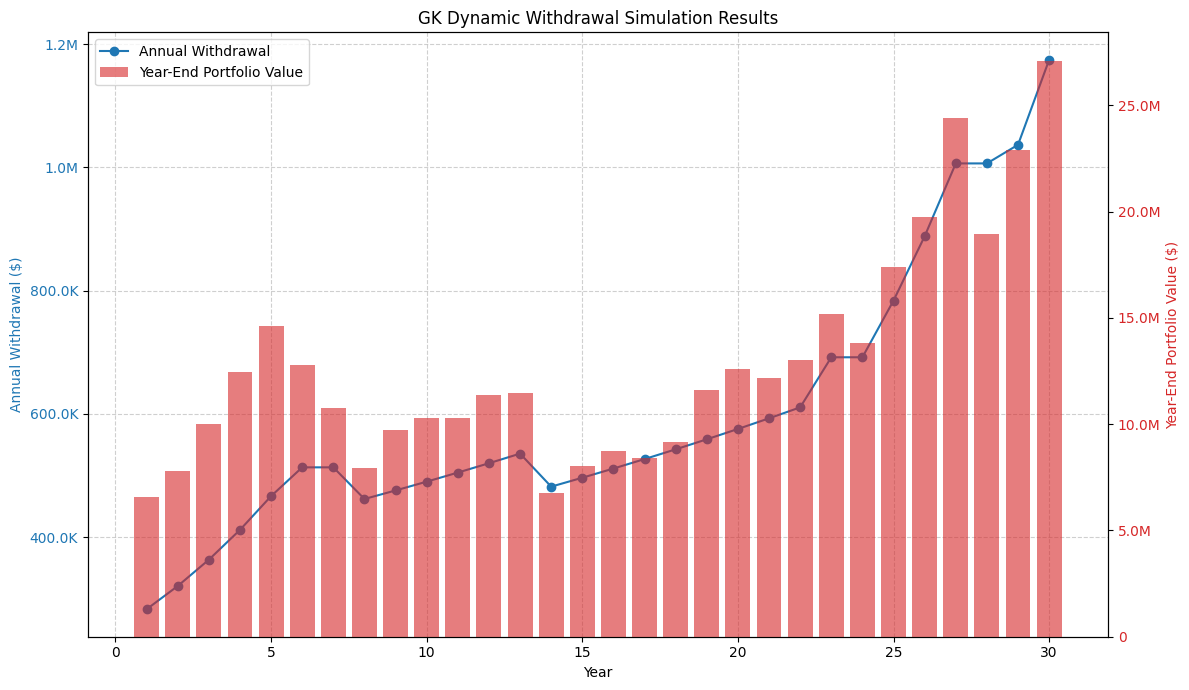

------------------------------


--- GK 動態提領模擬開始 ---
初始投資組合: $5,000,000.00
初始提領率: 5.00%
通膨率: 3.00%
------------------------------

--- 模擬結果: 退休金剩餘 $3,727,531.37 ---

---Bloomberg U.S. Aggregate Bond 指數總報酬率(美債) 詳細模擬結果 ---

--- 圖表英文對照表 Chart Glossary (English to Chinese) ---
GK Dynamic Withdrawal Simulation Results: GK 動態提領模擬結果
Year: 年份
Annual Withdrawal ($): 每年提領金額 ($)
Year-End Portfolio Value ($): 年底投資組合餘額 ($)
-------------------------------------------



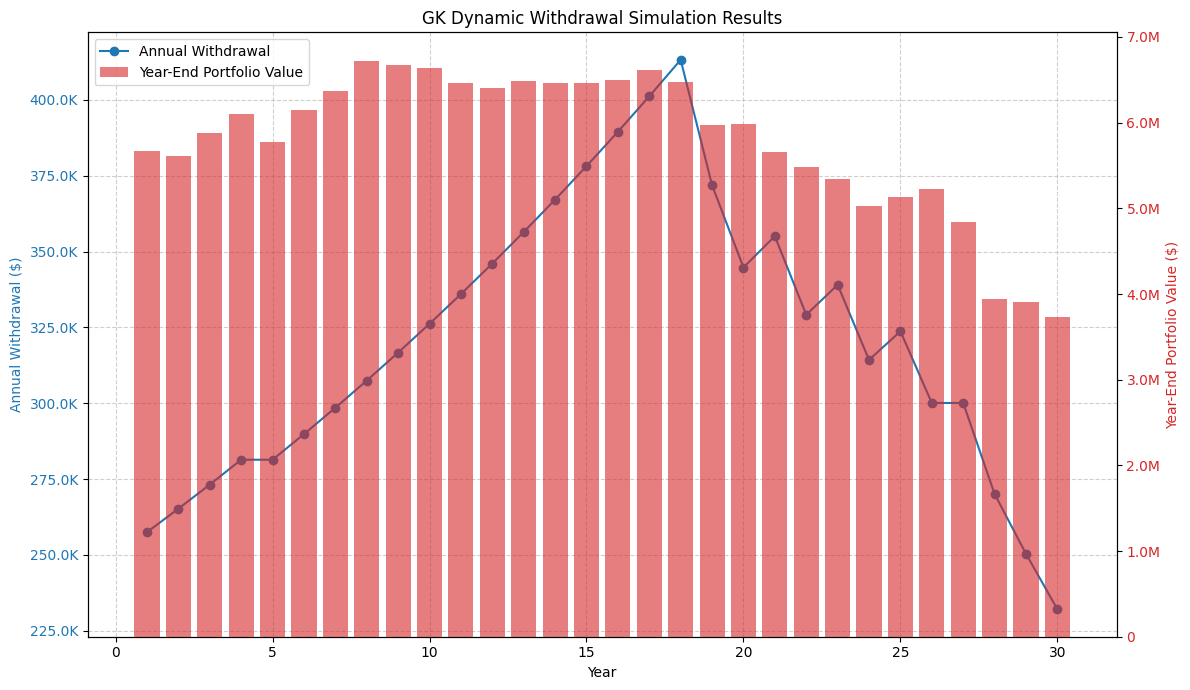

------------------------------


--- GK 動態提領模擬開始 ---
初始投資組合: $5,000,000.00
初始提領率: 5.00%
通膨率: 3.00%
------------------------------

--- 模擬結果: 退休金剩餘 $13,638,113.42 ---

---MSCI World 指數總報酬率(全球股) 詳細模擬結果 ---

--- 圖表英文對照表 Chart Glossary (English to Chinese) ---
GK Dynamic Withdrawal Simulation Results: GK 動態提領模擬結果
Year: 年份
Annual Withdrawal ($): 每年提領金額 ($)
Year-End Portfolio Value ($): 年底投資組合餘額 ($)
-------------------------------------------



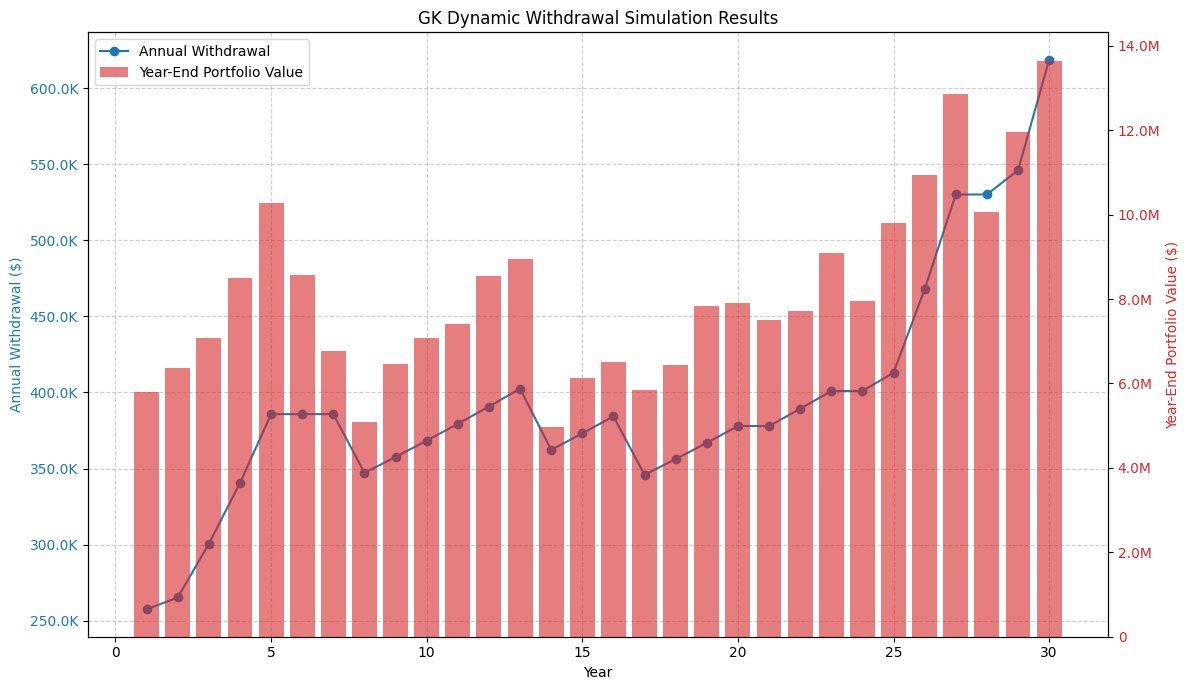

------------------------------




In [31]:
# @title 執行主要程式
# sample_annual_returns = get_random_annual_returns()

#樣本測試
sample_check = {'台灣加權股價報酬指數(台股)':taiex_returns,'S&P 500 指數總報酬率(美股)':sp500_returns,'Bloomberg U.S. Aggregate Bond 指數總報酬率(美債)':us_bond_returns,'MSCI World 指數總報酬率(全球股)':msci_world_returns}

for item, sample_annual_returns in sample_check.items():
  # 運行模擬
  simulation_results = gk_dynamic_withdrawal_simulation(
      initial_portfolio_value=initial_portfolio,
      initial_withdrawal_rate=initial_withdrawal_rate, # 4%
      inflation_rate=0.03, # 3% 假設通膨為3%
      annual_returns=sample_annual_returns
  )

  # 顯示結果 DataFrame
  print(f"\n---{item} 詳細模擬結果 ---\n")
  plot_withdraw_results(simulation_results)
  # print(simulation_results.to_string()) # 使用 to_string() 避免截斷顯示

  print('-'*30)
  print('\n')